In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import scipy 
from scipy import interpolate

import nifty7 as ift

2024-11-26 11:55:37.861798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Put the path where the software is stored**

In [2]:
soft_path = "/home/belen/Doctorado/ML/polarizacion/inhomogeneo/soft/" #put software path

In [3]:
sys.path.append(os.path.abspath(soft_path + "source/"))

In [4]:
import PowerSpectrum as PP

In [5]:
import utilities
import time

In [6]:
Lsize = 20
nx = 256
d2r = np.pi/180.
dx = Lsize*d2r / float(nx)# size of pixels in radians
dx_grad = Lsize/float(nx)
resolution = Lsize*60/float(nx) #arcmin

**Put the path where the data and results are stored, when call the models be aware of putting the same names as in the input dictionary**

In [7]:
lmin = 2
lmax = 2400
nbins = 25
modelb = 1
mask_mode = 0
data_folder = soft_path + "data/"
result_folder = soft_path + "results/"

#put mask1 or mask2 at the end of the name_mode depending of the case

name_model1 = "mask1/CNN_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"
name_model2 = "mask1/CNN_res1_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"
name_model3 = "mask1/CNN_res2_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"
name_model4 = "mask1/CNN_res3_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"
name_model5 = "mask1/CNN_res4_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"
name_modelb = "mask1/CNN_bdata_filters0_16_filters1_16_filters2_16_lr_3.36e-05_mask1.h5"

name_models = {"name_model1": result_folder + name_model1, "name_model2": result_folder + name_model2, "name_model3": result_folder + name_model3, "name_model4": result_folder + name_model4, "name_model5": result_folder + name_model5, "name_modelb": result_folder + name_modelb}

#normalization factors for the data
def get_factors(mask_mode):
    
    factorb = 2.5093405995359563
    factore = 0.16460073685016466
    
    if mask_mode == 0: #mask1
        factor1 = 0.23101459662555687
        factor2 = 1.4934063289079644
        factor3 = 2.1341465392589236
        factor4 = 2.225170141352581
        
        factors = {"factor1": factor1, "factor2": factor2, "factor3": factor3, "factor4": factor4, "factorb": factorb, "factore": factore}

    elif mask_mode == 1: #mask2 
        factor1 = 0.2768020126939169
        factor2 = 1.5843005570290416
        factor3 = 2.4755476349178056
        factor4 = 2.625848360627717
        factor5 = 2.670909663721945
        
        factors = {"factor1": factor1, "factor2": factor2, "factor3": factor3, "factor4": factor4, "factor5": factor5, "factorb": factorb, "factore": factore}
        
    return factors


factors = get_factors(mask_mode)

variance_map = np.load(data_folder + 'variance_QU_planck.npy')
variance_bmap = np.load(data_folder + 'variance_mapB_planck.npy')

masks = np.load(data_folder + 'masks_QU.npy')
if mask_mode == 0: 
    mask = masks[0]
else:
    mask = masks[1]


In [8]:
factors

{'factor1': 0.23101459662555687,
 'factor2': 1.4934063289079644,
 'factor3': 2.1341465392589236,
 'factor4': 2.225170141352581,
 'factorb': 2.5093405995359563,
 'factore': 0.16460073685016466}

**Load the fisher matrix from results folder** 

In [8]:
fisher_emap_2000_qu_01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_emap_planck1_mask2_modelqu0.1.npy')
fisher_emap_2000_qu_minus01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_emap_planck1_mask2_modelqu-0.1.npy')
fisher_emap_2000_qu_average_mask2 = (fisher_emap_2000_qu_01_mask2 + fisher_emap_2000_qu_minus01_mask2)/2

fisher_emap_2000_b_01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_emap_planck1_mask2_modelb0.1.npy')
fisher_emap_2000_b_minus01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_emap_planck1_mask2_modelb-0.1.npy')
fisher_emap_2000_b_average_mask2 = (fisher_emap_2000_b_01_mask2 + fisher_emap_2000_b_minus01_mask2)/2

fisher_bmap_2000_qu_01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_bmap_planck1_mask2_modelqu0.1.npy')
fisher_bmap_2000_qu_minus01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_bmap_planck1_mask2_modelqu-0.1.npy')
fisher_bmap_2000_qu_average_mask2 = (fisher_bmap_2000_qu_01_mask2 + fisher_bmap_2000_qu_minus01_mask2)/2

fisher_bmap_2000_b_01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_bmap_planck1_mask2_modelb0.1.npy')
fisher_bmap_2000_b_minus01_mask2 = np.load(result_folder + 'mask2/fisher_matrix_2000_bmap_planck1_mask2_modelb-0.1.npy')
fisher_bmap_2000_b_average_mask2 = (fisher_bmap_2000_b_01_mask2 + fisher_bmap_2000_b_minus01_mask2)/2


In [9]:
fisher_emap_2000_qu_01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_emap_planck1_mask1_modelqu0.1.npy')
fisher_emap_2000_qu_minus01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_emap_planck1_mask1_modelqu-0.1.npy')
fisher_emap_2000_qu_average_mask1 = (fisher_emap_2000_qu_01_mask1 + fisher_emap_2000_qu_minus01_mask1)/2

fisher_emap_2000_b_01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_emap_planck1_mask1_modelb0.1.npy')
fisher_emap_2000_b_minus01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_emap_planck1_mask1_modelb-0.1.npy')
fisher_emap_2000_b_average_mask1 = (fisher_emap_2000_b_01_mask1 + fisher_emap_2000_b_minus01_mask1)/2

fisher_bmap_2000_qu_01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_bmap_planck1_mask1_modelqu0.1.npy')
fisher_bmap_2000_qu_minus01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_bmap_planck1_mask1_modelqu-0.1.npy')
fisher_bmap_2000_qu_average_mask1 = (fisher_bmap_2000_qu_01_mask1 + fisher_bmap_2000_qu_minus01_mask1)/2

fisher_bmap_2000_b_01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_bmap_planck1_mask1_modelb0.1.npy')
fisher_bmap_2000_b_minus01_mask1 = np.load(result_folder + 'mask1/fisher_matrix_2000_bmap_planck1_mask1_modelb-0.1.npy')
fisher_bmap_2000_b_average_mask1 = (fisher_bmap_2000_b_01_mask1 + fisher_bmap_2000_b_minus01_mask1)/2



Text(0.5, 1.0, 'Fisher BB modelb mask2')

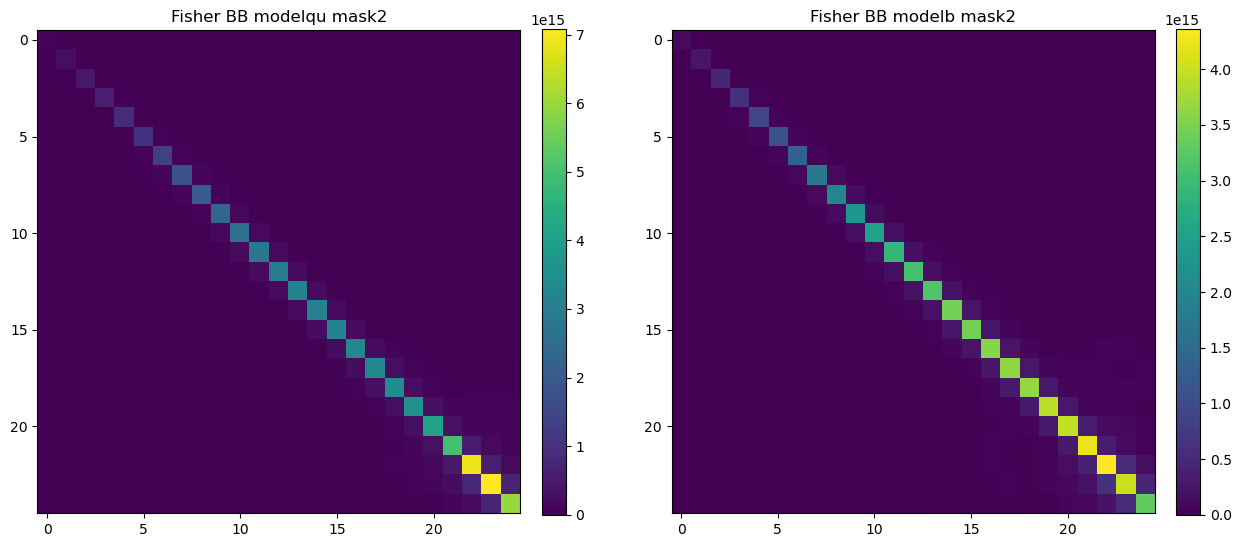

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
cero = ax[0].imshow(fisher_bmap_2000_qu_average_mask2)
fig.colorbar(cero, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title('Fisher BB modelqu mask2')

uno = ax[1].imshow(fisher_bmap_2000_b_average_mask2)
fig.colorbar(uno, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title('Fisher BB modelb mask2')

Text(0.5, 1.0, 'Fisher BB modelb mask2')

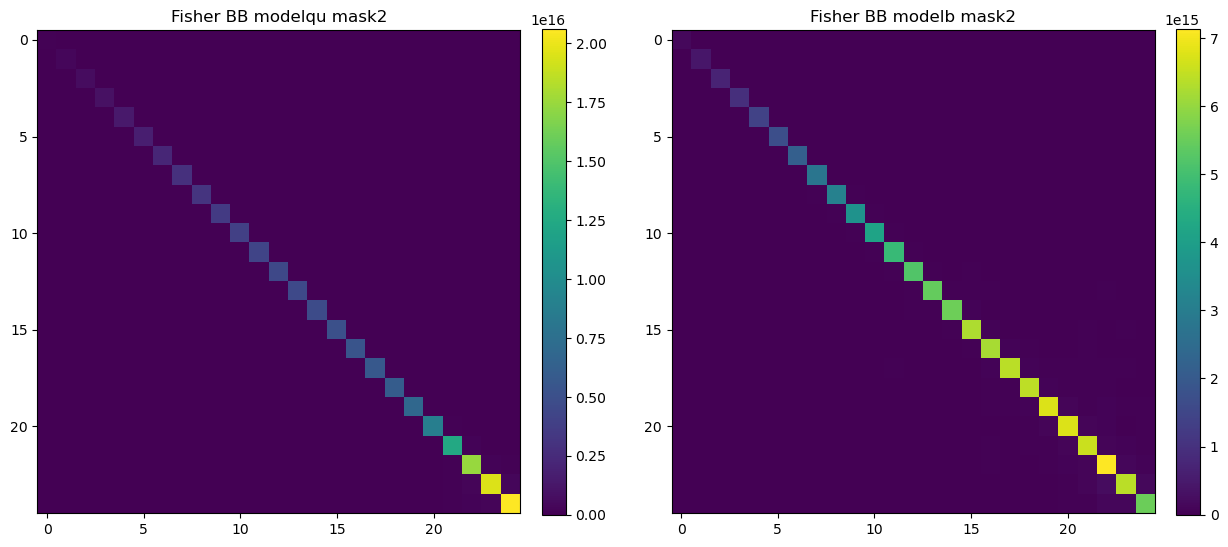

In [30]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
cero = ax[0].imshow(fisher_bmap_2000_qu_average_mask1)
fig.colorbar(cero, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title('Fisher BB modelqu mask2')

uno = ax[1].imshow(fisher_bmap_2000_b_average_mask1)
fig.colorbar(uno, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title('Fisher BB modelb mask2')

**Read true power spectrum that we wish to estimate**

In [10]:
cl_ang_e, cl_ang_b = utilities.signal_spectrum()
_,_, bin_edges = utilities.compute_bins(lmin,lmax,nbins) 

cl_true_12sigma = np.load(data_folder + 'true_spectrum_12sigma.npz')
cl_true_e_12sigma = cl_true_12sigma['arr_0']
cl_true_b_12sigma = cl_true_12sigma['arr_1']

Total number of modes in (l_min,l_max) =  5764797.0
Number of modes in each bin =  230591.88


In [11]:
ele = np.arange(len(cl_ang_b))

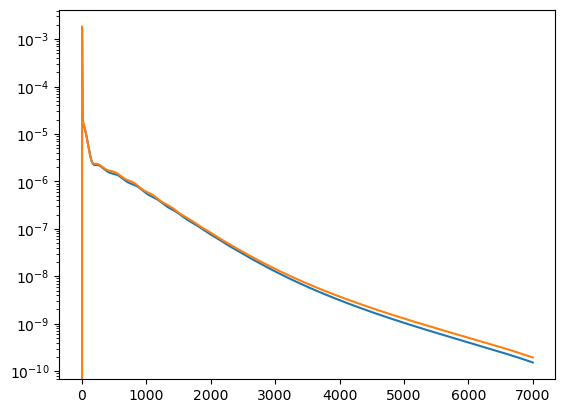

In [81]:
plt.plot(ele, cl_ang_b)
plt.plot(ele, cl_true_b_12sigma[:7001])
plt.yscale('log')

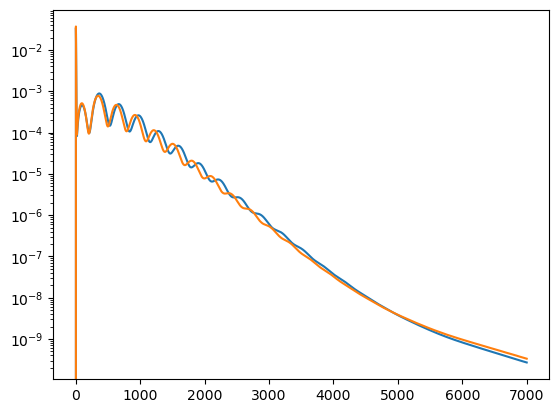

In [77]:
plt.plot(ele, cl_ang_e)
plt.plot(ele, cl_true_e_12sigma[:7001])
plt.yscale('log')

In [12]:
npad = 256
ps = PP.PowerSpectrum(Lsize, nx, npad, nbins, bin_edges, modelb, mask_mode, mask, variance_map, variance_bmap)


In [15]:
nbins

25

In [13]:
ell_flat, cl_ee = ps.flat_spectrum(cl_ang_e)
ell_flat, cl_bb = ps.flat_spectrum(cl_ang_b)

In [14]:
_, cl_ee_true_12sigma = ps.flat_spectrum(cl_true_e_12sigma)
_, cl_bb_true_12sigma = ps.flat_spectrum(cl_true_b_12sigma)

In [15]:
el_bin_fid_e, cl_bin_fid_e, count = ps.bineado(ell_flat, cl_ee)
el_bin_fid_b, cl_bin_fid_b, count = ps.bineado(ell_flat, cl_bb)

In [16]:
el_bin_true_e_12sigma, cl_bin_true_e_12sigma, count = ps.bineado(ell_flat, cl_ee_true_12sigma)
el_bin_true_b_12sigma, cl_bin_true_b_12sigma, count = ps.bineado(ell_flat, cl_bb_true_12sigma)

**Load noise bias term from results folder**

In [17]:
bl_e_modelqu_mask2 = np.load(result_folder + 'mask2/noise_bias_100_emap_planck1_mask2_modelqu.npy')
bl_b_modelqu_mask2 = np.load(result_folder + 'mask2/noise_bias_100_bmap_planck1_mask2_modelqu.npy')

bl_e_modelb_mask2 = np.load(result_folder + 'mask2/noise_bias_100_emap_planck1_mask2_modelb.npy')
bl_b_modelb_mask2 = np.load(result_folder + 'mask2/noise_bias_100_bmap_planck1_mask2_modelb.npy')

bl_e_modelqu_mask1 = np.load(result_folder + 'mask1/noise_bias_100_emap_planck1_mask1_modelqu.npy')
bl_b_modelqu_mask1 = np.load(result_folder + 'mask1/noise_bias_100_bmap_planck1_mask1_modelqu.npy')

bl_e_modelb_mask1 = np.load(result_folder + 'mask1/noise_bias_100_emap_planck1_mask1_modelb.npy')
bl_b_modelb_mask1 = np.load(result_folder + 'mask1/noise_bias_100_bmap_planck1_mask1_modelb.npy')


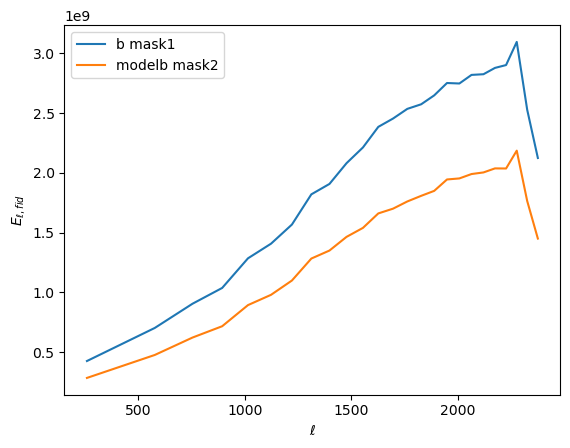

In [48]:
plt.plot(el_bin_fid_b, bl_b_modelb_mask1, label='b mask1')
plt.plot(el_bin_fid_b, bl_b_modelb_mask2, label='modelb mask2')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$E_{\ell,fid}$')
plt.legend()

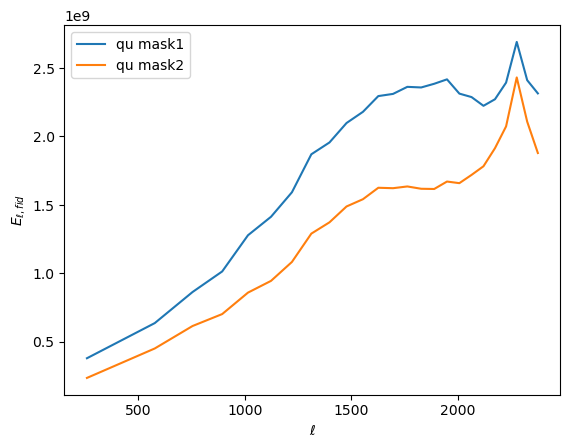

In [18]:
plt.plot(el_bin_fid_b, bl_b_modelqu_mask1, label='qu mask1')
plt.plot(el_bin_fid_b, bl_b_modelqu_mask2, label='qu mask2')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$E_{\ell,fid}$')
plt.legend()
plt.legend()

In [18]:
print('using modelb =', modelb)

using modelb = 1


In [19]:
print('using mask_mode =', mask_mode)  #mask_mode = 1 is Mask2 and mask_mode = 0 is Mask1

using mask_mode = 0


In [20]:
print('loading models')
models = ps.get_models(factors, name_models)

loading models


In [ ]:
#calculate El_true

In [1]:
def El_modified(nsamples, cl_ang_e, cl_ang_b, modelb):
    
    prediction_true_e = np.zeros((nsamples,256,256))
    prediction_true_b = np.zeros((nsamples,256,256))
    t0 = time.time()

    #mapa_true = np.zeros((nsamples,512,512))
    for i in range(nsamples):
        qobs, uobs, qsky, usky, esky, bsky = ps.make_map_noseed(cl_ang_e, cl_ang_b)        
        if modelb == 1:
            prediction_e, prediction_b = ps.WF_red_bdato(qobs, uobs, factors, models)
        else: 
            prediction_e, prediction_b = ps.WF_red(qobs, uobs, factors, models)
        prediction_true_e[i] = prediction_e[0,:,:]
        prediction_true_b[i] = prediction_b[0,:,:]
        
    t1 = time.time()
    print('prediction time of 100 maps', t1-t0)
    np.savez('predicted_true_maps_maskmode_'+ str(mask_mode) + 'modelb_' + str(modelb), prediction_true_e, prediction_true_b)
    
    El_true_e = np.zeros((nsamples,25))
    El_true_b = np.zeros((nsamples,25))
    for i in range(nsamples):
        
        map_pred_e = prediction_true_e[i,:,:]
        map_pred_b = prediction_true_b[i,:,:]
        power_map_e = ps.power(map_pred_e)
        power_map_b = ps.power(map_pred_b)
        El_true_e[i] = ps.El_fid(ell_flat, cl_ee, power_map_e, cl_bin_fid_e) 
        El_true_b[i] = ps.El_fid(ell_flat, cl_bb, power_map_b, cl_bin_fid_b) 
        
    np.savez('El_true_maskmode_'+ str(mask_mode) + 'modelb_' + str(modelb), El_true_e, El_true_b)
        
    return El_true_e, El_true_b, prediction_true_e, prediction_true_b



In [22]:
nsamples = 100
El_true_e_12sigma, El_true_b_12sigma, prediction_true_e_12sigma, prediction_true_b_12sigma = El_modified(nsamples, cl_true_e_12sigma, cl_true_b_12sigma, modelb)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step
prediction time of 200 maps 957.6499216556549


In [27]:
El_mask2_modelqu = np.load(soft_path + 'tutorials/El_true_maskmode_1modelb_0.npz')
El_mask2_modelqu_e = El_mask2_modelqu["arr_0"]
El_mask2_modelqu_b = El_mask2_modelqu["arr_1"]

El_mask2_modelb = np.load(soft_path + 'tutorials/El_true_maskmode_1modelb_1.npz')
El_mask2_modelb_e = El_mask2_modelb["arr_0"]
El_mask2_modelb_b = El_mask2_modelb["arr_1"]

El_mask1_modelqu = np.load(soft_path + 'tutorials/El_true_maskmode_0modelb_0.npz')
El_mask1_modelqu_e = El_mask1_modelqu["arr_0"]
El_mask1_modelqu_b = El_mask1_modelqu["arr_1"]

El_mask1_modelb = np.load(soft_path + 'tutorials/El_true_maskmode_0modelb_1.npz') #verificado que esta bien 
El_mask1_modelb_e = El_mask1_modelb["arr_0"]
El_mask1_modelb_b = El_mask1_modelb["arr_1"]

In [32]:
def correction_modified(El_true, bl, fisher, cl_bin_fid, nsamples):
    
    fisher_inverse = np.linalg.inv(fisher)
    correction = np.zeros((nsamples,25))
    for i in range(nsamples):
        nuevo = El_true[i]-bl
        nuevo = np.reshape(nuevo, (25,1))
        correction_shape = np.dot(fisher_inverse, nuevo)
        correction[i,:]=np.reshape(correction_shape, (25))
    
    correction_mean = np.mean(correction, axis=0)
    correction_desv = np.std(correction, axis=0)
    
    estimation = cl_bin_fid + correction_mean
    
    return estimation, correction_desv, correction

In [33]:
estimationb_average_modelqu_mask1, desviationb_modelqu_mask1, correctionb_modelqu_mask1 = correction_modified(El_mask1_modelqu_b, bl_b_modelqu_mask1, fisher_bmap_2000_qu_average_mask1, cl_bin_fid_b, nsamples=100)
estimatione_average_modelqu_mask1, desviatione_modelqu_mask1, correctione_modelqu_mask1 = correction_modified(El_mask1_modelqu_e, bl_e_modelqu_mask1, fisher_emap_2000_qu_average_mask1, cl_bin_fid_e, nsamples=100)

estimationb_average_modelb_mask1, desviationb_modelb_mask1, correctionb_modelb_mask1 = correction_modified(El_mask1_modelb_b, bl_b_modelb_mask1, fisher_bmap_2000_b_average_mask1, cl_bin_fid_b, nsamples=100)
estimatione_average_modelb_mask1, desviatione_modelb_mask1, correctione_modelb_mask1 = correction_modified(El_mask1_modelb_e, bl_e_modelb_mask1, fisher_emap_2000_b_average_mask1, cl_bin_fid_e, nsamples=100)


In [34]:
estimationb_average_modelqu_mask2, desviationb_modelqu_mask2, correctionb_modelqu_mask2 = correction_modified(El_mask2_modelqu_b, bl_b_modelqu_mask2, fisher_bmap_2000_qu_average_mask2, cl_bin_fid_b, nsamples=100)
estimatione_average_modelqu_mask2, desviatione_modelqu_mask2, correctione_modelqu_mask2 = correction_modified(El_mask2_modelqu_e, bl_e_modelqu_mask2, fisher_emap_2000_qu_average_mask2, cl_bin_fid_e, nsamples=100)


estimationb_average_modelb_mask2, desviationb_modelb_mask2, correctionb_modelb_mask2 = correction_modified(El_mask2_modelb_b, bl_b_modelb_mask2, fisher_bmap_2000_b_average_mask2, cl_bin_fid_b, nsamples=100)
estimatione_average_modelb_mask2, desviatione_modelb_mask2, correctione_modelb_mask2 = correction_modified(El_mask2_modelb_e, bl_e_modelb_mask2, fisher_emap_2000_b_average_mask2, cl_bin_fid_e, nsamples=100)


In [36]:
estimationb_modelqu_mask1 = cl_bin_fid_b + correctionb_modelqu_mask1
estimatione_modelqu_mask1 = cl_bin_fid_e + correctione_modelqu_mask1
estimationb_modelb_mask1 = cl_bin_fid_b + correctionb_modelb_mask1
estimationb_modelb_mask1_200 = cl_bin_fid_b + correctionb_modelb_mask1_200



estimationb_modelb_mask2 = cl_bin_fid_b + correctionb_modelb_mask2
estimationb_modelqu_mask2 = cl_bin_fid_b + correctionb_modelqu_mask2
estimatione_modelqu_mask2 = cl_bin_fid_e + correctione_modelqu_mask2




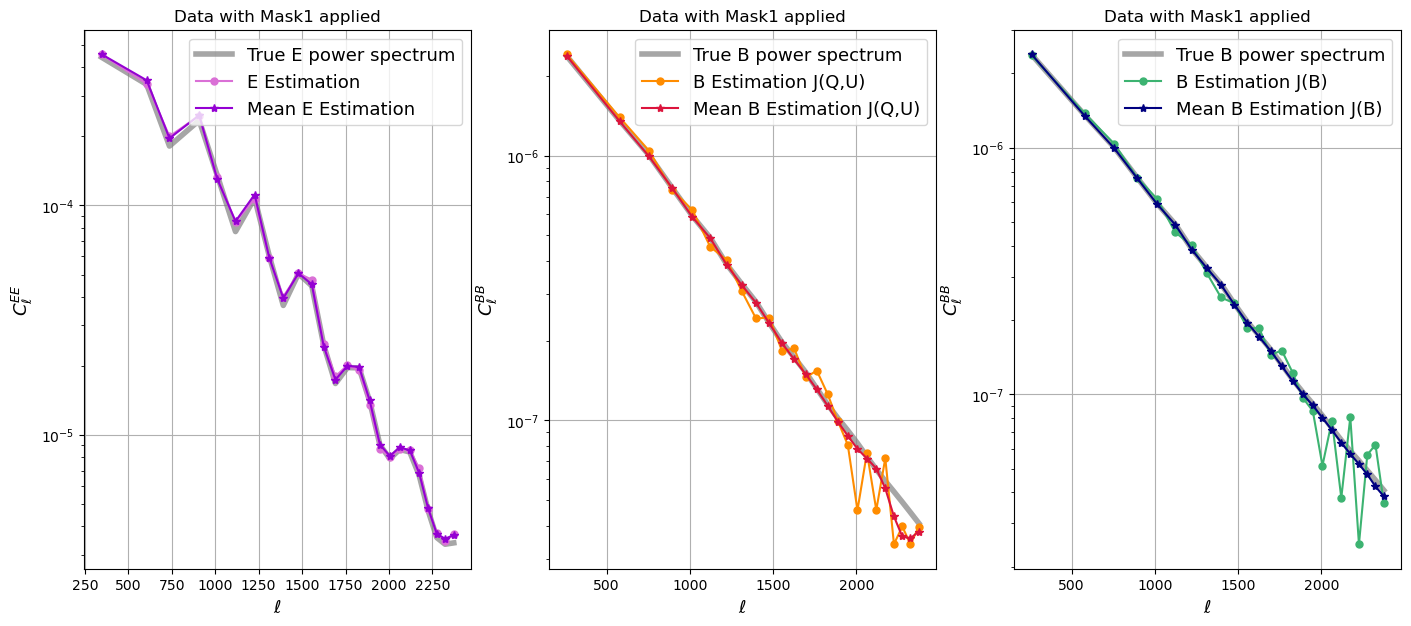

In [37]:
fig, ax = plt.subplots(1,3, figsize=(17,7))
#ax[0].plot(el_bin_fid_e, cl_bin_fid_e, label='fiducial')
ax[0].plot(el_bin_fid_e, cl_bin_true_e_12sigma, color='gray', lw=4, alpha=0.7, label='True E power spectrum')
ax[0].plot(el_bin_fid_e, estimatione_modelqu_mask1[6], marker='o', ms=5, color='orchid', label='E Estimation')
ax[0].plot(el_bin_fid_e, estimatione_average_modelqu_mask1, marker='*', color='darkviolet',label='Mean E Estimation')

ax[1].plot(el_bin_fid_b, cl_bin_true_b_12sigma, color='gray', lw=4, alpha=0.7, label='True B power spectrum')
ax[1].plot(el_bin_fid_b, estimationb_modelqu_mask1[6], marker='o', ms=5, color='darkorange',label='B Estimation J(Q,U)')
ax[1].plot(el_bin_fid_b, estimationb_average_modelqu_mask1, marker='*', color='crimson', label='Mean B Estimation J(Q,U)')

ax[2].plot(el_bin_fid_b, cl_bin_true_b_12sigma, color='gray', lw=4, alpha=0.7, label='True B power spectrum')
ax[2].plot(el_bin_fid_b, estimationb_modelb_mask1[6], marker='o', ms=5, color='mediumseagreen',label='B Estimation J(B)')
ax[2].plot(el_bin_fid_b, estimationb_average_modelb_mask1, marker='*', color='navy', label='Mean B Estimation J(B)')


ax[0].set_xlabel(r'$\ell$', fontsize=13)
ax[0].set_ylabel(r'$C^{EE}_{\ell}$', fontsize=13)

ax[1].set_xlabel(r'$\ell$', fontsize=13)
ax[1].set_ylabel(r'$C^{BB}_{\ell}$', fontsize=13)

ax[2].set_xlabel(r'$\ell$', fontsize=13)
ax[2].set_ylabel(r'$C^{BB}_{\ell}$', fontsize=13)


ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].legend(fontsize=13, loc='upper right')
ax[1].legend(fontsize=13)
ax[2].legend(fontsize=13)
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].set_title('Data with Mask1 applied')
ax[1].set_title('Data with Mask1 applied')
ax[2].set_title('Data with Mask1 applied')

plt.savefig('estimacion_espec_mask1_test.pdf', bbox_inches='tight')

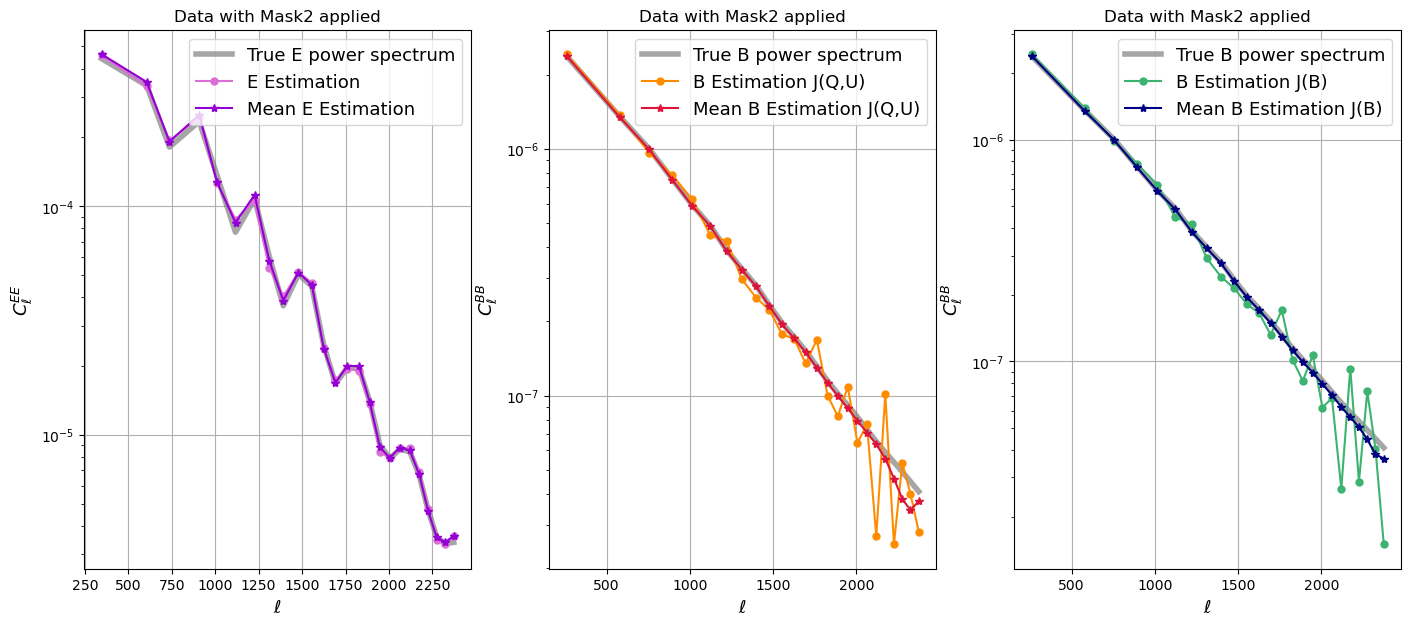

In [38]:
fig, ax = plt.subplots(1,3, figsize=(17,7))
#ax[0].plot(el_bin_fid_e, cl_bin_fid_e, label='fiducial')
ax[0].plot(el_bin_fid_e, cl_bin_true_e_12sigma, color='gray', lw=4, alpha=0.7, label='True E power spectrum')
ax[0].plot(el_bin_fid_e, estimatione_modelqu_mask2[6], marker='o', ms=5, color='orchid', label='E Estimation')
ax[0].plot(el_bin_fid_e, estimatione_average_modelqu_mask2, marker='*', color='darkviolet',label='Mean E Estimation')

ax[1].plot(el_bin_fid_b, cl_bin_true_b_12sigma, color='gray', lw=4, alpha=0.7, label='True B power spectrum')
ax[1].plot(el_bin_fid_b, estimationb_modelqu_mask2[6], marker='o', ms=5, color='darkorange',label='B Estimation J(Q,U)')
ax[1].plot(el_bin_fid_b, estimationb_average_modelqu_mask2, marker='*', color='crimson', label='Mean B Estimation J(Q,U)')

ax[2].plot(el_bin_fid_b, cl_bin_true_b_12sigma, color='gray', lw=4, alpha=0.7, label='True B power spectrum')
ax[2].plot(el_bin_fid_b, estimationb_modelb_mask2[6], marker='o', ms=5, color='mediumseagreen',label='B Estimation J(B)')
ax[2].plot(el_bin_fid_b, estimationb_average_modelb_mask2, marker='*', color='navy', label='Mean B Estimation J(B)')


ax[0].set_xlabel(r'$\ell$', fontsize=13)
ax[0].set_ylabel(r'$C^{EE}_{\ell}$', fontsize=13)

ax[1].set_xlabel(r'$\ell$', fontsize=13)
ax[1].set_ylabel(r'$C^{BB}_{\ell}$', fontsize=13)

ax[2].set_xlabel(r'$\ell$', fontsize=13)
ax[2].set_ylabel(r'$C^{BB}_{\ell}$', fontsize=13)


ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].legend(fontsize=13, loc='upper right')
ax[1].legend(fontsize=13)
ax[2].legend(fontsize=13)
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].set_title('Data with Mask2 applied')
ax[1].set_title('Data with Mask2 applied')
ax[2].set_title('Data with Mask2 applied')

plt.savefig('estimacion_espec_mask2_test.pdf', bbox_inches='tight')

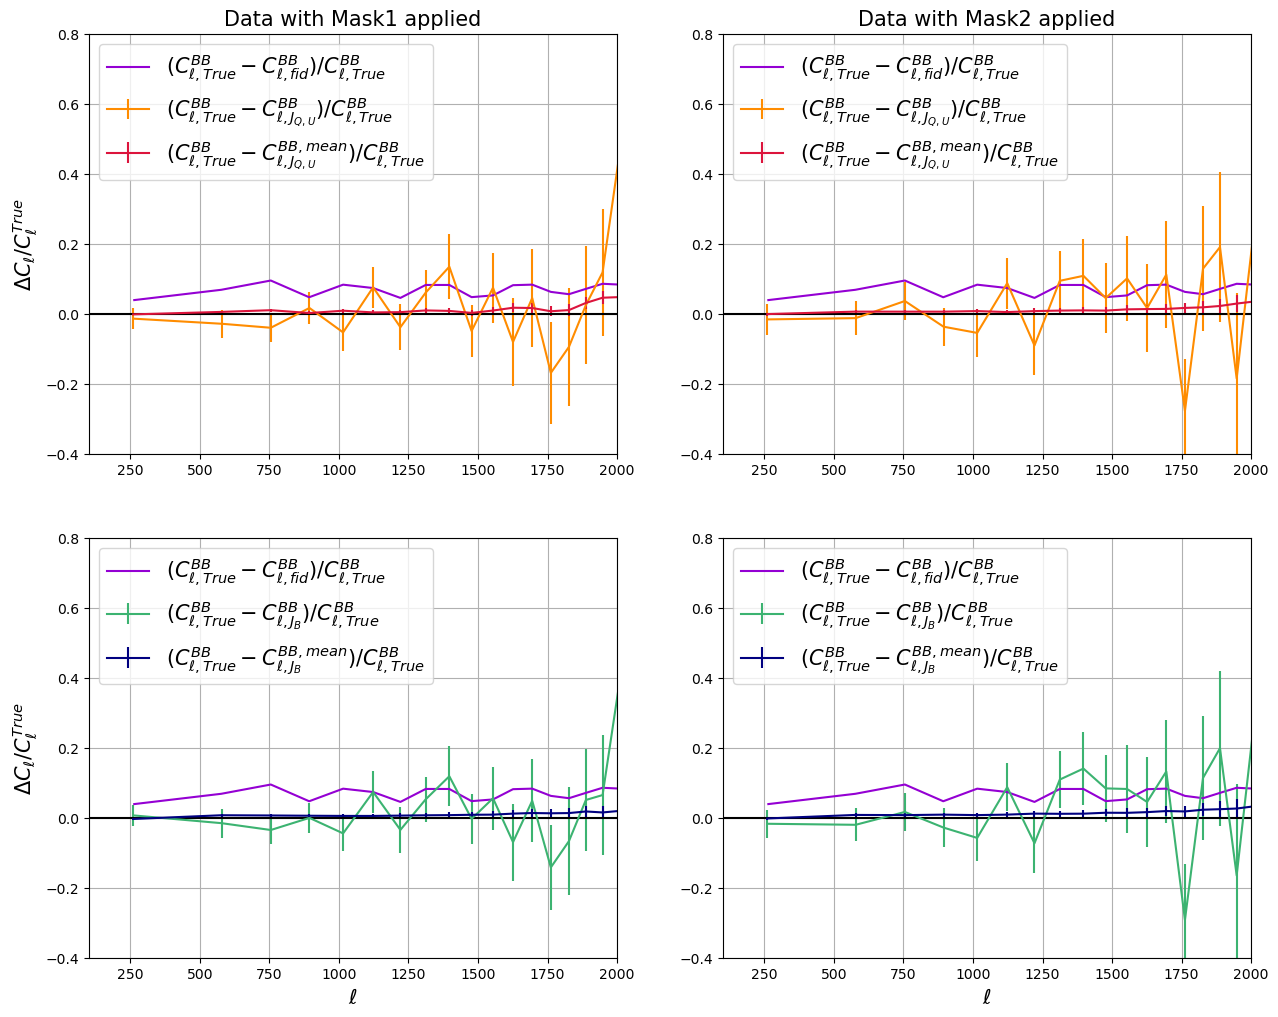

In [42]:
fig, ax=plt.subplots(2,2, figsize=(15,12))

#models B mask1
ax[0,0].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_modelqu_mask1[6])/cl_bin_true_b_12sigma, color='darkorange', yerr=desviationb_modelqu_mask1/cl_bin_true_b_12sigma, label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,J_{Q,U}})/C^{BB}_{\ell,True}$')
ax[1,0].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_modelb_mask1[6])/cl_bin_true_b_12sigma, color='mediumseagreen', yerr=desviationb_modelb_mask1/cl_bin_true_b_12sigma, label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,J_{B}})/C^{BB}_{\ell,True}$')

#models B mask1 media
ax[0,0].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_average_modelqu_mask1)/cl_bin_true_b_12sigma, color='crimson', yerr=desviationb_modelqu_mask1/cl_bin_true_b_12sigma/np.sqrt(100), label=r'$(C^{BB}_{\ell,True}-C^{BB, mean}_{\ell,J_{Q,U}})/C^{BB}_{\ell,True}$')
ax[1,0].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_average_modelb_mask1)/cl_bin_true_b_12sigma, color='navy', yerr=desviationb_modelb_mask1/cl_bin_true_b_12sigma/np.sqrt(100), label=r'$(C^{BB}_{\ell,True}-C^{BB, mean}_{\ell,J_{B}})/C^{BB}_{\ell,True}$')

#models B mask2
ax[0,1].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_modelqu_mask2[6])/cl_bin_true_b_12sigma, color='darkorange', yerr=desviationb_modelqu_mask2/cl_bin_true_b_12sigma, label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,J_{Q,U}})/C^{BB}_{\ell,True}$')
ax[1,1].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_modelb_mask2[6])/cl_bin_true_b_12sigma, color='mediumseagreen', yerr=desviationb_modelb_mask2/cl_bin_true_b_12sigma, label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,J_{B}})/C^{BB}_{\ell,True}$')

#models B mask2 media
ax[0,1].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_average_modelqu_mask2)/cl_bin_true_b_12sigma, color='crimson', yerr=desviationb_modelqu_mask2/cl_bin_true_b_12sigma/np.sqrt(100), label=r'$(C^{BB}_{\ell,True}-C^{BB, mean}_{\ell,J_{Q,U}})/C^{BB}_{\ell,True}$')
ax[1,1].errorbar(el_bin_fid_b, (cl_bin_true_b_12sigma - estimationb_average_modelb_mask2)/cl_bin_true_b_12sigma, color='navy', yerr=desviationb_modelb_mask2/cl_bin_true_b_12sigma/np.sqrt(100), label=r'$(C^{BB}_{\ell,True}-C^{BB, mean}_{\ell,J_{B}})/C^{BB}_{\ell,True}$')


ax[0,0].plot(el_bin_true_b_12sigma, (cl_bin_true_b_12sigma-cl_bin_fid_b)/cl_bin_true_b_12sigma, color='darkviolet', label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,fid})/C^{BB}_{\ell,True}$')
ax[1,0].plot(el_bin_true_b_12sigma, (cl_bin_true_b_12sigma-cl_bin_fid_b)/cl_bin_true_b_12sigma, color='darkviolet', label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,fid})/C^{BB}_{\ell,True}$')

ax[0,1].plot(el_bin_true_b_12sigma, (cl_bin_true_b_12sigma-cl_bin_fid_b)/cl_bin_true_b_12sigma, color='darkviolet', label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,fid})/C^{BB}_{\ell,True}$')
ax[1,1].plot(el_bin_true_b_12sigma, (cl_bin_true_b_12sigma-cl_bin_fid_b)/cl_bin_true_b_12sigma, color='darkviolet', label=r'$(C^{BB}_{\ell,True}-C^{BB}_{\ell,fid})/C^{BB}_{\ell,True}$')

ax[0,0].axhline(y=0., color='black')
ax[0,1].axhline(y=0., color='black')

ax[1,0].axhline(y=0., color='black')
ax[1,1].axhline(y=0., color='black')

ax[0,0].legend(fontsize=15, loc='upper left')
ax[0,1].legend(fontsize=15, loc='upper left')

ax[1,0].legend(fontsize=15, loc='upper left')
ax[1,1].legend(fontsize=15, loc='upper left')

#ax[0,0].set_xlabel(r'$\ell$', fontsize=15)
ax[0,0].set_ylabel(r'$\Delta C_{\ell}/C_{\ell}^{True}$', fontsize=15)
#ax[0,1].set_xlabel(r'$\ell$', fontsize=15)

ax[1,0].set_xlabel(r'$\ell$', fontsize=15)
ax[1,0].set_ylabel(r'$\Delta C_{\ell}/C_{\ell}^{True}$', fontsize=15)
ax[1,1].set_xlabel(r'$\ell$', fontsize=15)


ax[0,0].set_ylim(-0.4,0.8)
ax[0,0].set_xlim(100,2000)

ax[0,1].set_ylim(-0.4,0.8)
ax[0,1].set_xlim(100,2000)

ax[1,0].set_ylim(-0.4,0.8)
ax[1,0].set_xlim(100,2000)

ax[1,1].set_ylim(-0.4,0.8)
ax[1,1].set_xlim(100,2000)

ax[0,0].grid()
ax[0,1].grid()

ax[1,0].grid()
ax[1,1].grid()


ax[0,0].set_title('Data with Mask1 applied', fontsize=15)
#ax[1,0].set_title('Data with Mask1 applied', fontsize=15)

ax[0,1].set_title('Data with Mask2 applied', fontsize=15)
#ax[1,1].set_title('Data with Mask2 applied', fontsize=15)

plt.savefig('dif_espec_mask1_mask2_test.pdf', bbox_inches='tight')

In [43]:
fisher_inv_bmap_modelqu_2000_mask1 = np.linalg.inv(fisher_bmap_2000_qu_average_mask1) 
fisher_inv_bmap_modelb_2000_mask1 = np.linalg.inv(fisher_bmap_2000_b_average_mask1) 

fisher_inv_bmap_modelqu_2000_mask2 = np.linalg.inv(fisher_bmap_2000_qu_average_mask2) 
fisher_inv_bmap_modelb_2000_mask2 = np.linalg.inv(fisher_bmap_2000_b_average_mask2) 



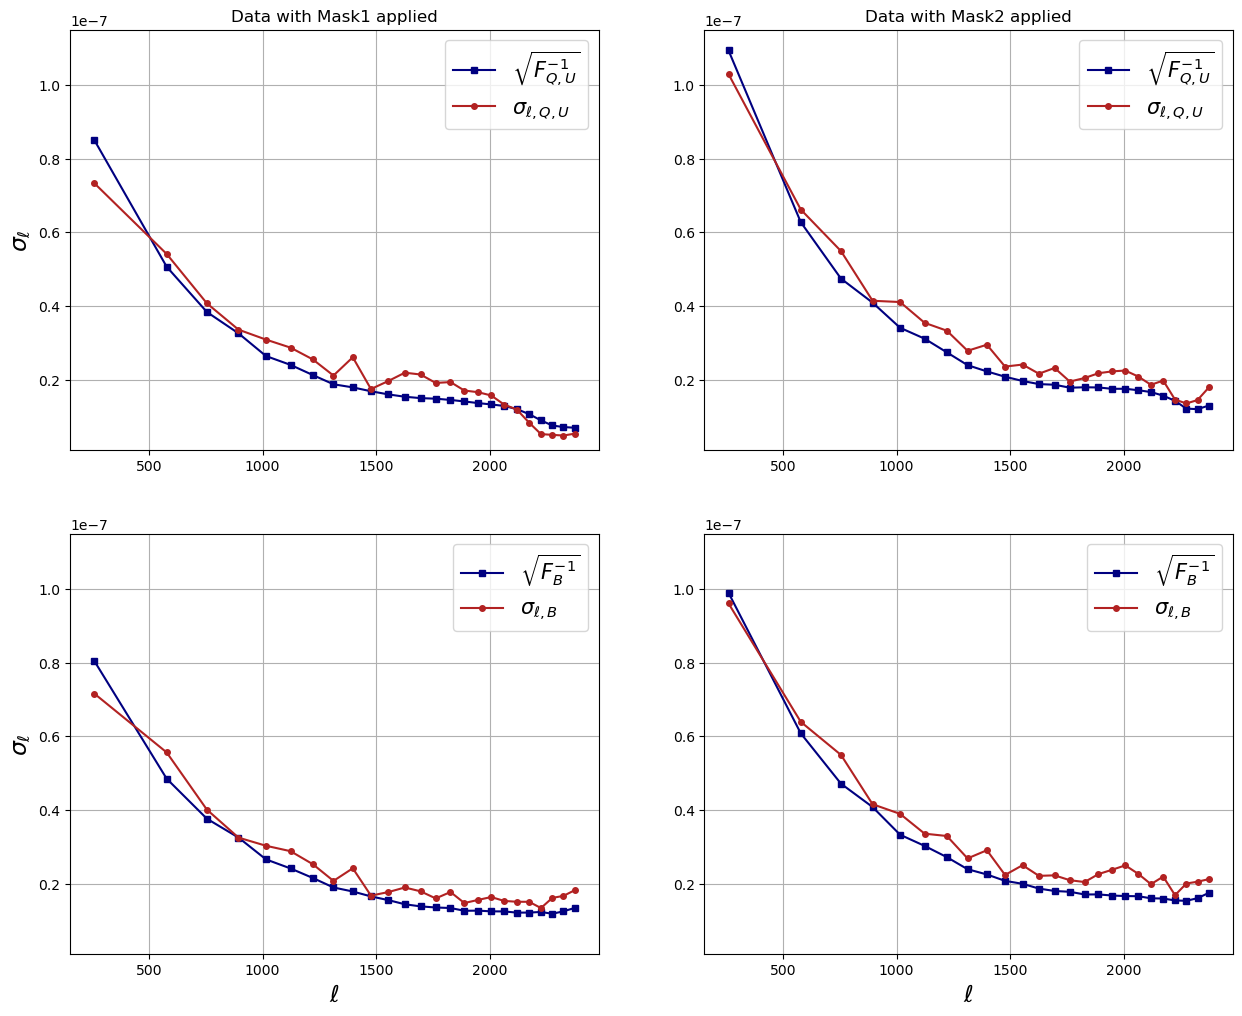

In [44]:
fig, ax=plt.subplots(2,2, figsize=(15,12))

#fisher mode B model QU with mask1
ax[0,0].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelqu_2000_mask1.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{Q,U}^{-1}}$')
ax[0,0].plot(el_bin_fid_b, desviationb_modelqu_mask1, marker='o',ms=4,color='firebrick',label=r'$\sigma_{\ell,Q,U}$')
#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
#ax[0,0].set_xlabel(r'$\ell$', fontsize=17)
ax[0,0].legend(fontsize=15)

#fisher mode B modelo QU with mask2
ax[0,1].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelqu_2000_mask2.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{Q,U}^{-1}}$')
ax[0,1].plot(el_bin_fid_b, desviationb_modelqu_mask2, marker='o',ms=4,color='firebrick',label=r'$\sigma_{\ell,Q,U}$')
#ax[0,0].set_yscale('log')
#ax[0,1].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
#ax[0,0].set_xlabel(r'$\ell$', fontsize=17)
ax[0,1].legend(fontsize=15)

#fisher mode B model B with mask1 
ax[1,0].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelb_2000_mask1.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{B}^{-1}}$')
ax[1,0].plot(el_bin_fid_b, desviationb_modelb_mask1, marker='o',ms=4,color='firebrick',label=r'$\sigma_{\ell,B}$')
#ax[1,0].set_yscale('log')
ax[1,0].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
ax[1,0].set_xlabel(r'$\ell$', fontsize=17)
ax[1,0].legend(fontsize=15)

#fisher mode B modelo B with mask2
ax[1,1].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelb_2000_mask2.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{B}^{-1}}$')
ax[1,1].plot(el_bin_fid_b, desviationb_modelb_mask2, marker='o',ms=4,color='firebrick',label=r'$\sigma_{\ell,B}$')
#ax[1,0].set_yscale('log')
#ax[1,1].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
ax[1,1].set_xlabel(r'$\ell$', fontsize=17)
ax[1,1].legend(fontsize=15)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()

ax[0,0].set_ylim(0.01e-7, 1.15e-7)
ax[1,0].set_ylim(0.01e-7, 1.15e-7)
ax[0,1].set_ylim(0.01e-7, 1.15e-7)
ax[1,1].set_ylim(0.01e-7, 1.15e-7)

#y_min = min(np.min(desv_b_12sigma_modelque), np.min(desv_b_12sigma_modelque_mask))
#y_max = max(np.max(desv_b_12sigma_modelque), np.max(desv_b_12sigma_modelque_mask))

#ax[0,0].set_ylim(y_min, y_max)
#ax[0,1].set_ylim(y_min, y_max)

ax[0,0].set_title('Data with Mask1 applied')
ax[0,1].set_title('Data with Mask2 applied')



plt.savefig('errores_fisher_mask1_mask2_test.pdf',bbox_inches='tight')

In [3]:
#calculate the approximate fisher matrix and compare with errors

In [60]:
mask_flatten = masks[0].flatten()
len(mask_flatten)  #128*128

area_mapa = len(mask_flatten)
pixel_no_tapa = np.where(masks[0]==1.)
area_no_tapada = masks[0][pixel_no_tapa]

fsky1 = len(area_no_tapada)/area_mapa
fsky1

0.97003173828125

In [61]:
mask_flatten = masks[1].flatten()
len(mask_flatten)  #128*128

area_mapa = len(mask_flatten)
pixel_no_tapa = np.where(masks[1]==1.)
area_no_tapada = masks[1][pixel_no_tapa]

fsky2 = len(area_no_tapada)/area_mapa
fsky2

0.67706298828125

In [62]:
rad2arcmin = 180.*60./np.pi


In [63]:
noise_level = np.sqrt((np.mean(variance_bmap))*dx**2*rad2arcmin**2)

In [2]:
def El_teorico_repetidos(ell_flat, cl_plane, cl_bin_repetidos_fid, nl, bins): 
    
    suma = np.zeros(25)
    for i in range(len(ell_flat)): 
        el = ell_flat[i]
        for j in range(len(bins)-1):  
            if el>=bins[j] and el<bins[j+1]:  
                suma[j]+=cl_plane[i]/(cl_plane[i]+nl[i])
    El = (1/2.)*(suma/cl_bin_repetidos_fid)

    return El

In [65]:
nl_homo = (noise_level*np.pi/180./60.)**2

In [66]:
nltt = np.zeros_like(cl_bb) 
nltt[:] = nl_homo

In [67]:
count

array([2224., 2244., 2236., 2232., 2228., 2232., 2224., 2236., 2212.,
       2288., 2212., 2220., 2216., 2272., 2244., 2212., 2228., 2216.,
       2272., 2268., 2228., 2180., 2232., 1862., 1576.])

In [68]:
El_teorico_fid = El_teorico_repetidos(ell_flat, cl_bb, cl_bin_fid_b, nltt, bin_edges)

In [69]:
fisher_teorico_fid = 2*(El_teorico_fid**2)/count


In [71]:
factor = np.sqrt(fsky1/fsky2)

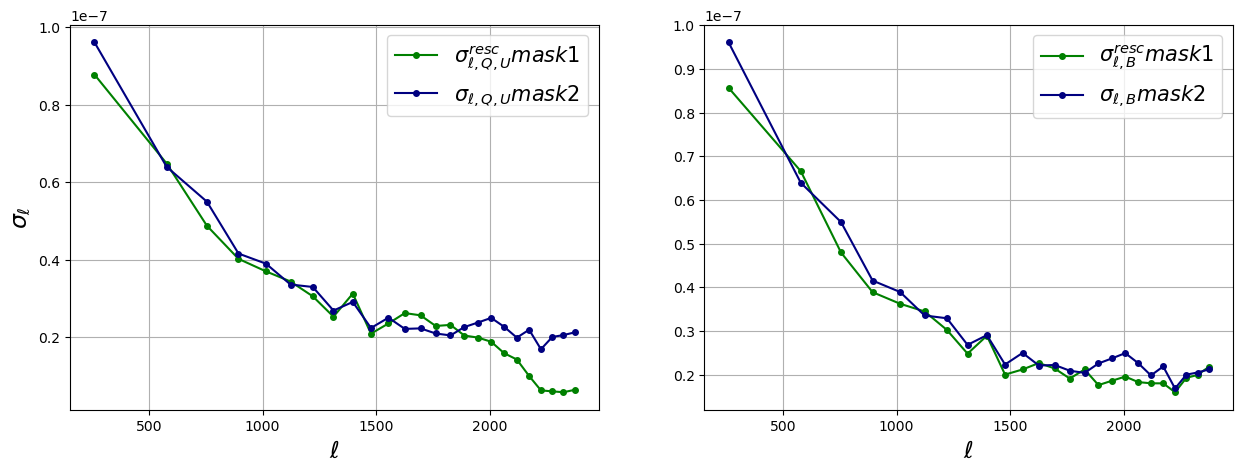

In [72]:
fig, ax=plt.subplots(1,2, figsize=(15,5))

#fisher mode B model QU with mask1
#ax[0,0].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelqu_2000_mask1.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{Q,U}^{-1}}$')
ax[0].plot(el_bin_fid_b, desviationb_modelqu_mask1*factor, marker='o',ms=4,color='green',label=r'$\sigma^{resc}_{\ell,Q,U} mask1$')
#ax[0,0].set_yscale('log')
ax[0].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
ax[0].set_xlabel(r'$\ell$', fontsize=17)
#ax[0].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelqu_2000_mask2.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{Q,U}^{-1}}$')
ax[0].plot(el_bin_fid_b, desviationb_modelb_mask2, marker='o',ms=4,color='navy',label=r'$\sigma_{\ell,Q,U} mask2$')
ax[0].legend(fontsize=15)


#fisher mode B modele B with mask1 
#ax[1].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelbe_2000_mask1.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{B}^{-1}}$')
ax[1].plot(el_bin_fid_b, desviationb_modelb_mask1*factor, marker='o',ms=4,color='green',label=r'$\sigma^{resc}_{\ell,B} mask1$')
#ax[1,0].set_yscale('log')
#ax[1].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
ax[1].set_xlabel(r'$\ell$', fontsize=17)
ax[1].legend(fontsize=15)
#ax[1].plot(el_bin_fid_b, np.sqrt(fisher_inv_bmap_modelbe_2000_mask2.diagonal()), marker='s', ms=4, color='navy',label=r'$\sqrt{F_{B}^{-1}}$')
ax[1].plot(el_bin_fid_b, desviationb_modelb_mask2, marker='o',ms=4,color='navy',label=r'$\sigma_{\ell,B} mask2$')
#ax[1,0].set_yscale('log')
#ax[1,1].set_ylabel(r'$\sigma_{\ell}$', fontsize=17)
ax[1].set_xlabel(r'$\ell$', fontsize=17)
ax[1].legend(fontsize=15)

ax[0].grid()
ax[1].grid()

#ax[0].set_title('Data with Mask1 applied')
#ax[1].set_title('Data with Mask2 applied')


plt.savefig('desv_mask1_mask2_test.pdf',bbox_inches='tight')